# Bayesian inference using MCMC - Metropolis-Hasting algorithm

In [38]:
import numpy as np
from scipy.stats import norm,gamma

In [2]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False
}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

# Synthetic data 

In [3]:
mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with mean=10 and scale=3
y = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
yobs = y[np.random.randint(0, 30000, 1000)]

(10.032942828621763, 2.959017924171079)

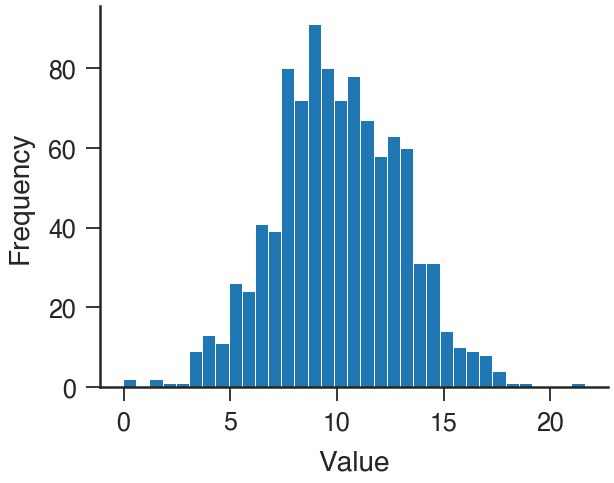

In [4]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
ax.hist(yobs,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
yobs.mean(),yobs.std()

# Bayesian model

In [39]:
class Normal:
    
    """
    Normal distribution 
    """
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.dist = norm(loc=mu, scale=sigma)

    def pdf(self, x):
        return self.dist.pdf(x)

    def logpdf(self, x):
        return self.dist.logpdf(x)
    
    def sample(self, n):
        return self.dist.rvs(n)

class Gamma:
    
    """
    Gamma distribution 
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.dist = gamma(a=alpha,scale=1/beta)

    def pdf(self, x):
        return self.dist.pdf(x)

    def logpdf(self, x):
        return self.dist.logpdf(x)
    
    def sample(self, n):
        return self.dist.rvs(n)


In [67]:
def model_loglikelihood(mu, sigma, y):
    """
    Log-likelihood 
    """
    # log-probability of mu under prior.
    normal_prior = Normal(0, 1)
    mu_log_prob = normal_prior.logpdf(mu)

    # log-probability of sigma under prior.
    sigma_prior = Gamma(11,1)
    sigma_log_prob = sigma_prior.logpdf(sigma)

    # log-likelihood given priors and data
    likelihood = Normal(mu, sigma)
    likelihood_log_prob = likelihood.logpdf(y).sum()

    # Joint log-likelihood
    return mu_log_prob + sigma_log_prob + likelihood_log_prob


In [68]:
def metropolis_hastings(y,model,params,iterations):

    """
    Metropolis-Hastings Sampling
    """
    # Initial parameters
    mu_old=params[0]
    sigma_old=params[1]
    
    # Keep a history of the parameter values and ratio.
    mu_history = []
    sigma_history = [] 
    ratio_history=[]
    accepted=[]
    rejected=[]
    for i in range(iterations):
        mu_history.append(mu_old)
        sigma_history.append(sigma_old)
        
        mu_new=np.random.normal(mu_old,params[1])
        sigma_new=np.random.normal(sigma_old, params[1])
        
        llik_old = model(mu_old, sigma_old, y) 
        llik_new = model(mu_new, sigma_new, y)  
        
        if llik_new>llik_old or (np.log(np.random.uniform(0,1)) < (llik_new-llik_old)):            
            mu_old=mu_new
            sigma_old=sigma_new
            accepted.append(llik_new)
        else:
            rejected.append(llik_new)
            
    return np.array(mu_history), np.array(sigma_history),np.array(accepted),np.array(rejected)

In [116]:
mu_history,sigma_history,accepted,rejected=metropolis_hastings(y,model_loglikelihood,
                                                               [np.mean(y),0.02*np.std(y)],
                                                               iterations=10**4)

In [117]:
len(accepted),len(rejected)

(1021, 8979)

## Convergence of parameters 

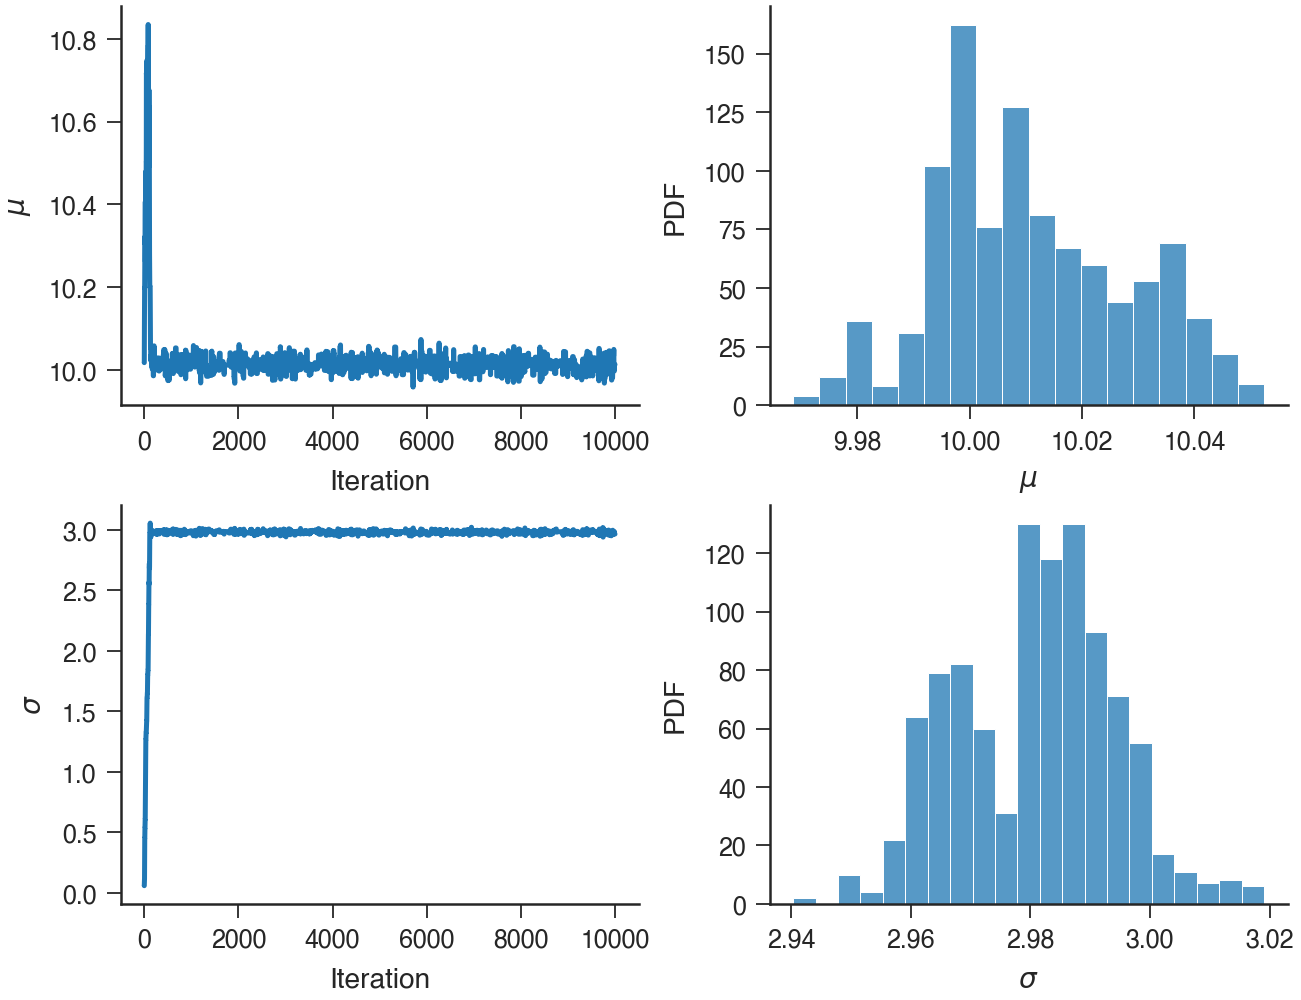

In [118]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]
ax.plot(mu_history[:])
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\mu$")

ax=axs.flatten()[1]
sns.histplot(mu_history[-1000:],ax=ax)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"PDF")

ax=axs.flatten()[2]
ax.plot(sigma_history[:])
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\sigma$")

ax=axs.flatten()[3]
sns.histplot(sigma_history[-1000:],ax=ax)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"PDF")
f.tight_layout()

Text(0, 0.5, 'Log-likelihood')

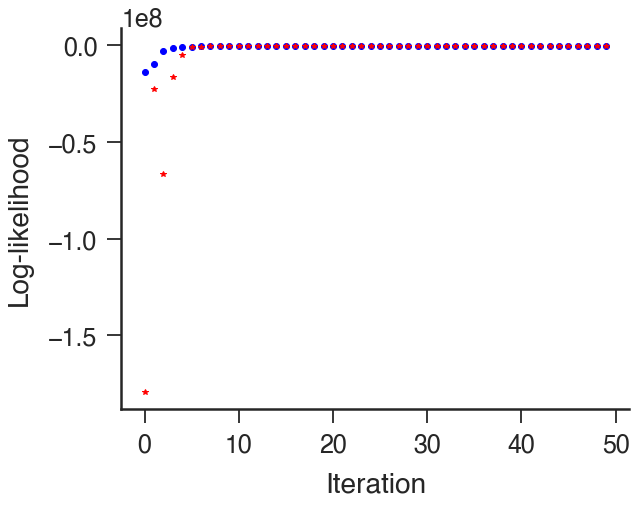

In [119]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
ax.plot(accepted[:50],'ob')
ax.plot(rejected[:50],'*r')

ax.set_xlabel("Iteration")
ax.set_ylabel(r"Log-likelihood")

# Prediction vs. data

In [120]:
y.shape[0]

30000

In [121]:
print(mu_history[-1000:].mean(), sigma_history[-1000:].mean())
model = lambda x,mu,sigma:np.random.normal(mu,sigma,x)
yhat=model(y.shape[0],mu_history[-1000:].mean(),sigma_history[-1000:].mean())

10.01073542874874 2.9810206215308224


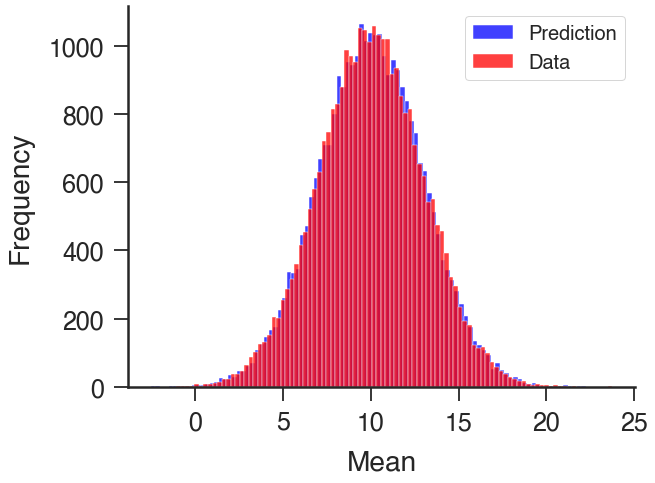

In [122]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
sns.histplot( yhat,ax=ax,label="Prediction",color='blue')
sns.histplot( y, ax=ax,label="Data",color='red')
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.legend()

# Autocorrelation function

In [123]:
from statsmodels.tsa.stattools import acf

/Users/lgaalves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Auto-correlation, $\\mu$')]

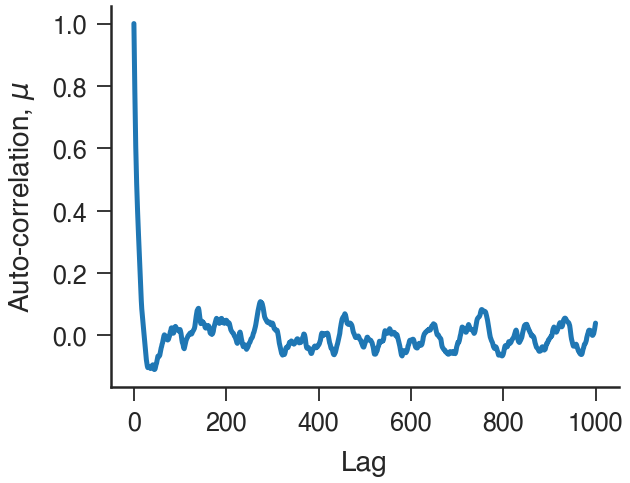

In [124]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
ax.plot(acf(mu_history[-5000:],nlags=1000))
ax.set(xlabel='Lag', ylabel='Auto-correlation, $\mu$')

/Users/lgaalves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Auto-correlation, $\\sigma$')]

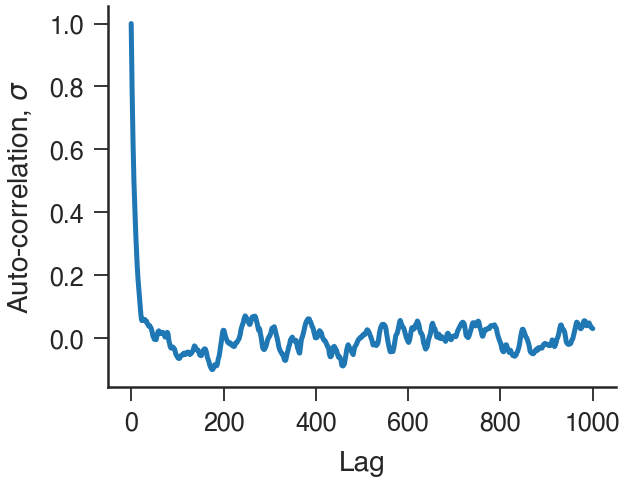

In [125]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
ax.plot(acf(sigma_history[-5000:],nlags=1000))
ax.set(xlabel='Lag', ylabel='Auto-correlation, $\sigma$')